# Python/Kerasで深層学習：
# MNISTからAAEで類似画像生成

https://github.com/eriklindernoren/Keras-GAN/blob/master/aae/adversarial_autoencoder.py

<pre>
Adversarial Auto-Encoderで類似画像生成
</pre>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  
session = tf.Session(config=config)
import keras
from keras import backend as K
K.set_session(session) 

Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [3]:
from collections import defaultdict
ae_history = defaultdict(list)

In [4]:
class AdversarialAutoencoder():
    def __init__(self):
        self.img_rows = 28 # 画像の縦サイズ
        self.img_cols = 28 # 画像の横サイズ
        self.channels = 1 # 画像のチャネルサイズ
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.encoded_dim = 100 # エンコーダの次元数

        optimizer = Adam(0.0002, 0.5) # 最適化関数

        # ディスクリミネータを生成しコンパイル
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,# ディスクリミネータは2値エントロピー（分類）問題
            metrics=['accuracy'])

        # エンコーダとデコーダを生成
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # ジェネレータは入力画像をエンコードし、デコーダで再構成する
        encoded_repr = self.encoder(img)
        reconstructed_img = self.decoder(encoded_repr)

        # ディスクリミネータは常に正しいとし、こちらは訓練で変更しない
        self.discriminator.trainable = False

        # ディスクリミネータがエンコードされたデータの妥当性を決定する
        validity = self.discriminator(encoded_repr)

        # 敵対的なオードエンコーダモデル (ジェネレータとディスクリミネータをスタックさせる)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],# オートエンコーダは
            optimizer=optimizer) # 平均2乗誤差(回帰)と2値エントロピー（分類）の２つの問題


    def build_encoder(self):
        # エンコーダ
        encoder = Sequential()

        encoder.add(Flatten(input_shape=self.img_shape)) #画像を平坦化する
        encoder.add(Dense(512))
        encoder.add(LeakyReLU(alpha=0.2))# 負の部分にわずかな傾きを与える活性化関数
        encoder.add(BatchNormalization(momentum=0.8))# 正規化(偏差は1よりわずかに小さくする)
        encoder.add(Dense(512))
        encoder.add(LeakyReLU(alpha=0.2))# 負の部分にわずかな傾きを与える活性化関数
        encoder.add(BatchNormalization(momentum=0.8))# 正規化(偏差は1よりわずかに小さくする)
        encoder.add(Dense(self.encoded_dim))# 隠れ層の次元だけ出力

        encoder.summary()

        img = Input(shape=self.img_shape)
        encoded_repr = encoder(img)

        return Model(img, encoded_repr)

    def build_decoder(self):
        # デコーダ
        decoder = Sequential()

        decoder.add(Dense(512, input_dim=self.encoded_dim))
        decoder.add(LeakyReLU(alpha=0.2))# 負の部分にわずかな傾きを与える活性化関数
        decoder.add(BatchNormalization(momentum=0.8))# 正規化(偏差は1よりわずかに小さくする)
        decoder.add(Dense(512))
        decoder.add(LeakyReLU(alpha=0.2))# 負の部分にわずかな傾きを与える活性化関数
        decoder.add(BatchNormalization(momentum=0.8))# 正規化(偏差は1よりわずかに小さくする)
        decoder.add(Dense(np.prod(self.img_shape), activation='tanh'))
        decoder.add(Reshape(self.img_shape)) # 3次元（縦サイズx横サイズxチャネル）に戻す

        decoder.summary()

        encoded_repr = Input(shape=(self.encoded_dim,))
        gen_img = decoder(encoded_repr)

        return Model(encoded_repr, gen_img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.encoded_dim))
        model.add(LeakyReLU(alpha=0.2))# 負の部分にわずかな傾きを与える活性化関数
        model.add(BatchNormalization(momentum=0.8))# 正規化(偏差は1よりわずかに小さくする)
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))# 負の部分にわずかな傾きを与える活性化関数
        model.add(BatchNormalization(momentum=0.8))# 正規化(偏差は1よりわずかに小さくする)
        model.add(Dense(1, activation="sigmoid"))# 出力は確率値（実数）
        model.summary()

        encoded_repr = Input(shape=(self.encoded_dim, ))# ディスクリミネータ入力は隠れ層次元
        validity = model(encoded_repr)

        return Model(encoded_repr, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # データセットをロード（テストデータは使わない）
        (X_train, _), (_, _) = mnist.load_data()

        # [0,255]の画像を[-1,1]の実数値に再スケール
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):


            # ---------------------
            #  ディスクリミネータの訓練
            # ---------------------

            # ランダムに半分のバッチのインデックスを生成
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # ランダムに半分のバッチ埋込画像を選択
            latent_fake = self.encoder.predict(imgs)

            latent_real = np.random.normal(size=(half_batch, self.encoded_dim))

            valid = np.ones((half_batch, 1))
            fake = np.zeros((half_batch, 1))

            # ディスクリミネータの訓練開始
            d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  ジェネレータの訓練
            # ---------------------

            # バッチサイズからランダムにインデックス生成
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # ジェネレータはバッチサイズ分、すべて模倣成功と思う 
            valid_y = np.ones((batch_size, 1))

            # ジェネレータの訓練開始（train_on_batchでバッチ分だけ重み係数更新）
            g_loss = self.adversarial_autoencoder.train_on_batch(\
                    imgs, [imgs, valid_y])

            
            # 侵食状況をモニタリング
            if epoch % 500 == 0:
                ae_history['d_loss'].append(d_loss[0])
                ae_history['d_loss_1'].append(d_loss[1])
                ae_history['g_loss'].append(g_loss[0])
                ae_history['g_loss_1'].append(g_loss[1])
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % \
                   (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

            # 定期的に画像をセーブ
            if epoch % sample_interval == 0:
                # Select a random half batch of images
                num_images = 30 # 25
                idx = np.random.randint(0, X_train.shape[0], num_images)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)

    def sample_images(self, epoch, imgs):
        r, c = 5, 6

        encoded_imgs = self.encoder.predict(imgs)
        gen_imgs = self.decoder.predict(encoded_imgs)

        #gen_imgs = 0.5 * gen_imgs + 0.5
        print(gen_imgs.shape, gen_imgs.dtype)

        plt.figure(figsize=(7,5)) # figsize=(14,10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                img = gen_imgs[cnt, :,:,0]
                cnt += 1
                plt.subplot(r,c,cnt)
                plt.axis('off')
                plt.imshow(img, cmap='gray', aspect='equal')

        
        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        plt.savefig("images/mnist_%d.png" % epoch)
        plt.close()

        plt.figure(figsize=(7,5)) # figsize=(14,10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                img = imgs[cnt, :,:,0]

                cnt += 1
                plt.subplot(r,c,cnt)
                plt.axis('off')
                plt.imshow(img, cmap='gray', aspect='equal')        
        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        plt.savefig("images/mnist_%d-true.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "aae_generator")
        save(self.discriminator, "aae_discriminator")

In [5]:
from time import gmtime, strftime
import datetime

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

aae = AdversarialAutoencoder()
now = datetime.datetime.now() # 現在の日時を取得
print('-------------------------------')
print('現在時刻 before AAE',now)
print('-------------------------------')
aae.train(epochs=10000, batch_size=32, sample_interval=500)
now = datetime.datetime.now() # 現在の日時を取得
print('-------------------------------')
print('現在時刻 after AAE 10000 epochs',now)
print('-------------------------------')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total para

In [6]:
import pickle
with open('pkl/AAE-history.pkl', 'wb') as f:
    pickle.dump({'g_loss': ae_history['g_loss'], 'd_loss': ae_history['d_loss']}, f)

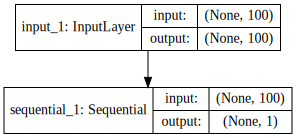

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
plot_model(aae.discriminator, show_shapes=True, to_file='images/Python-MNIST-AAE-Discriminator.jpg')

SVG(model_to_dot(aae.discriminator,show_shapes=True).create(prog='dot', format='svg'))

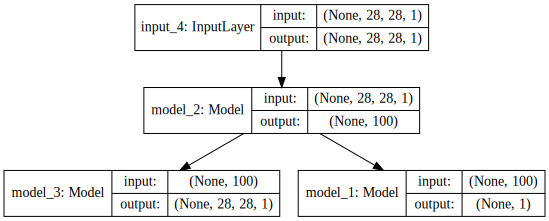

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
plot_model(aae.adversarial_autoencoder, show_shapes=True, to_file='images/Python-MNIST-AAE.jpg')

SVG(model_to_dot(aae.adversarial_autoencoder,show_shapes=True).create(prog='dot', format='svg'))

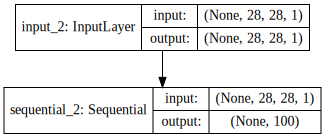

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
plot_model(aae.encoder, show_shapes=True, to_file='images/Python-MNIST-Encoder.jpg')

SVG(model_to_dot(aae.encoder,show_shapes=True).create(prog='dot', format='svg'))

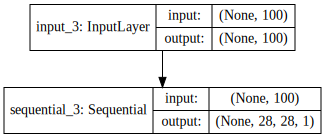

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
plot_model(aae.decoder, show_shapes=True, to_file='images/Python-MNIST-Decoder.jpg')

SVG(model_to_dot(aae.decoder,show_shapes=True).create(prog='dot', format='svg'))

In [11]:
# Matplotlibのフォントの制御（大きさや種類）
%matplotlib inline
import numpy as np # Numpy
import matplotlib
import matplotlib.pyplot as plt # 描画ライブラリ
print (matplotlib.rcParams.get('font.family'))
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

font_prop = fm.FontProperties()  
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()# フォントプロパティ(FP)をコピー
fp2.set_size('20')# フォントプロパティ(FP)をコピー
fp2.set_family('serif')# フォントはSerif(明朝体など）に設定

['sans-serif']


<class 'list'> 20


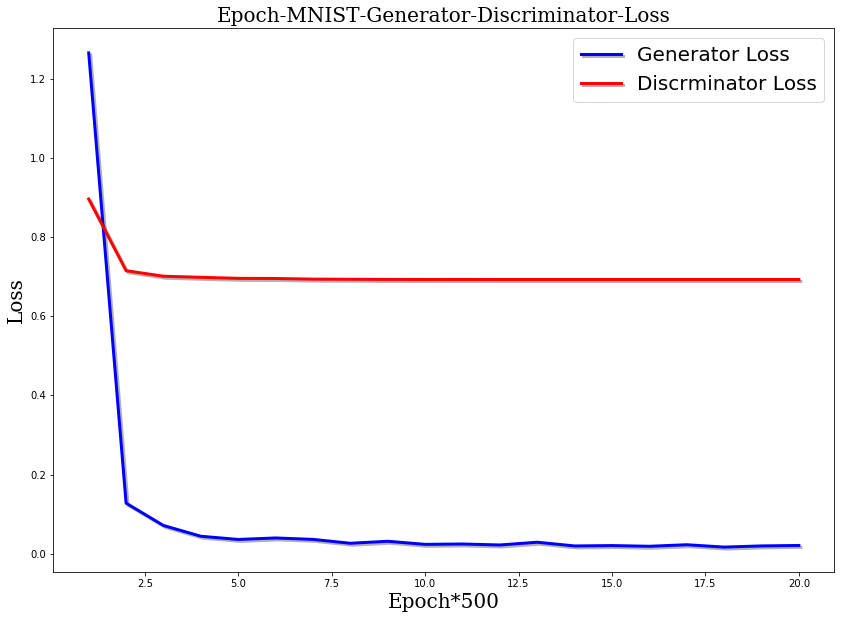

In [12]:
g_1 = ae_history['g_loss']
d_1 = ae_history['d_loss']

print(type(g_1), len(g_1)) # array([1.3826841 , 0.96553123, 0.41715324], dtype=float32)...

n = len(g_1)

generator_loss = np.zeros([n], dtype=float)
discriminator_loss = np.zeros([n], dtype=float)

for i in range(n):
    generator_loss[i] = g_1[i] # g_1[i][0]
    discriminator_loss[i] = d_1[i]
    
x_axis = np.zeros([n],dtype=int)
for i in range(len(x_axis)):
    x_axis[i] = i+1

# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(x_axis, generator_loss, 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(x_axis, discriminator_loss, 
         color='r', 
         linestyle='-',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])


plt.title('Epoch-MNIST-Generator-Discriminator-Loss',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch*500',fontsize=20,font_properties=fp2)
plt.legend(['Generator Loss', 'Discrminator Loss'],  
           loc='best', fontsize=20)
plt.savefig('pdf/Epoch-MNIST-Generator-Discriminator-Loss.pdf')
plt.show()

Epoch 0 True


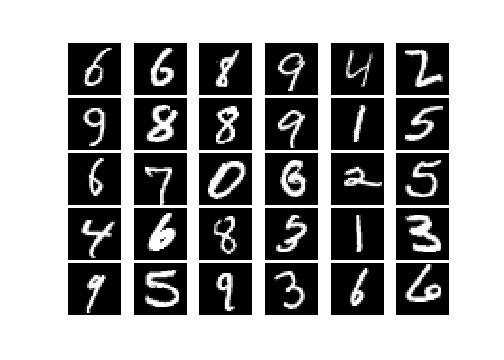

In [13]:
from IPython.display import Image
print("Epoch 0 True")
Image("images/mnist_0-true.png",width="400")

Epoch 0 Fake


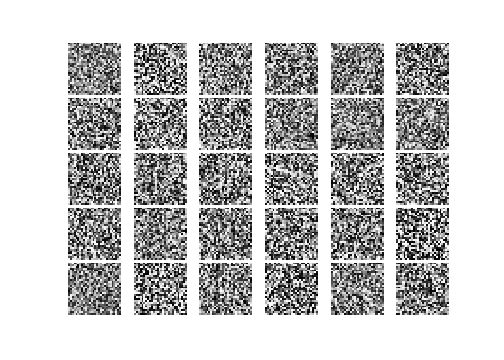

In [14]:
from IPython.display import Image
print("Epoch 0 Fake")
Image("images/mnist_0.png",width="400")

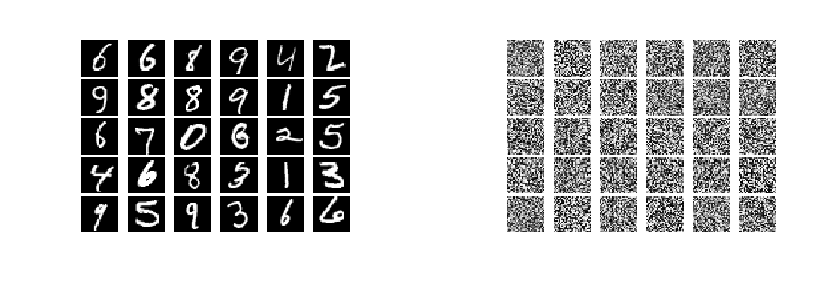

In [15]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(14,10))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

showImagesHorizontally(["images/mnist_0-true.png","images/mnist_0.png"])

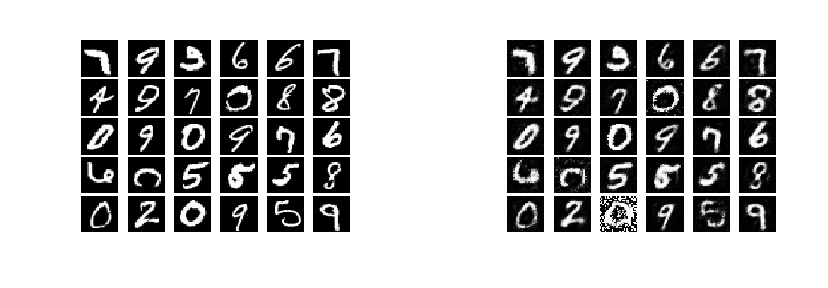

In [16]:
showImagesHorizontally(["images/mnist_1000-true.png","images/mnist_1000.png"])

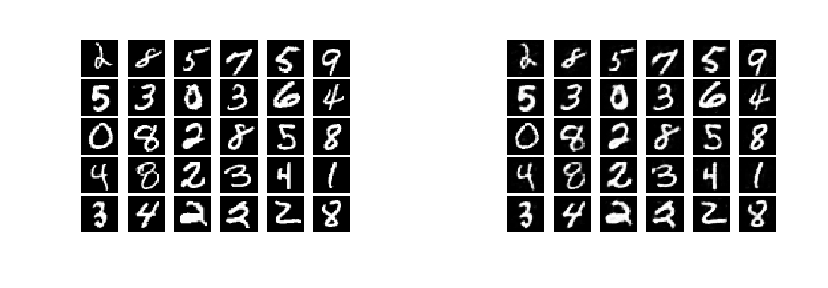

In [17]:
showImagesHorizontally(["images/mnist_5000-true.png","images/mnist_5000.png"])

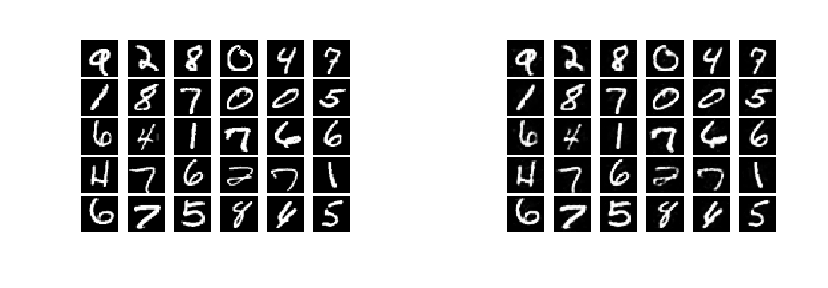

In [18]:
showImagesHorizontally(["images/mnist_9500-true.png","images/mnist_9500.png"])